In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.x13 import x13_arima_analysis, x13_arima_select_order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("../data/raw_data.csv").rename(columns = {"DATE": "date", "Hard coal consumption per capita [tones]": "consumption"})
df.date = pd.to_datetime(df.date).dt.date

df

,date,consumption
0,1994-07-01,0.076
1,1994-08-01,0.097
2,1994-09-01,0.140
3,1994-10-01,0.213
4,1994-11-01,0.345
...,...,...
313,2020-08-01,0.005
314,2020-09-01,0.009
315,2020-10-01,0.028
316,2020-11-01,0.081


<AxesSubplot:title={'center':'Hard coal consumption per capita [tones]'}, xlabel='date'>

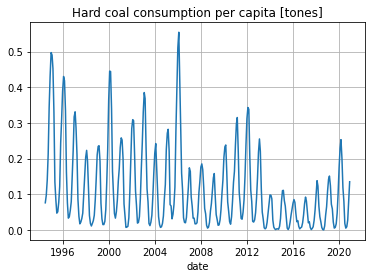

In [3]:
df.plot(x = "date", legend = False, title = "Hard coal consumption per capita [tones]", grid = True)

In [4]:
# print(kpss(df.consumption, nlags=12))
# print(kpss(df.consumption.diff().dropna(), nlags=12))
print(adfuller(df.consumption, maxlag=12))

(-4.150342523447282, 0.0007987112476294385, 12, 305, {'1%': -3.451973573620699, '5%': -2.8710633193086648, '10%': -2.5718441306100512}, -1441.0625563591223)


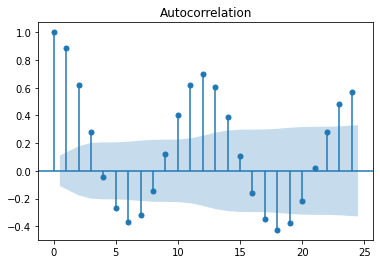

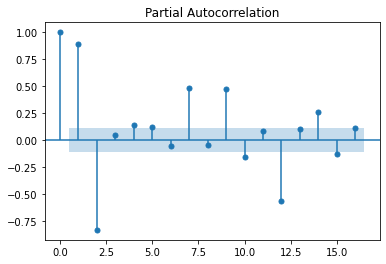

In [5]:
plot_acf(df.consumption, lags=24, alpha=.05, use_vlines=True)
plot_pacf(df.consumption, lags=16, alpha=.05, use_vlines=True)
print()

*Additive Moving Average seasonal decomposition*

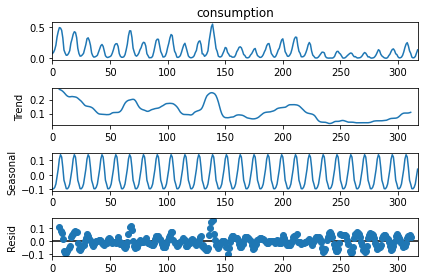

In [6]:
season_decomp_add = seasonal_decompose(df.consumption, model="additive", period=12)
season_decomp_add.plot()

df["resid_ma"] = season_decomp_add.resid.to_numpy()
df["sadj_ma"] = season_decomp_add.trend.to_numpy() + season_decomp_add.resid.to_numpy()

sadj_ma = df.sadj_ma.dropna().to_numpy()

In [27]:
print(adfuller(sadj_ma, maxlag=12))

(-3.1962994283800485, 0.020199884571858527, 6, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, -1455.991395513752)


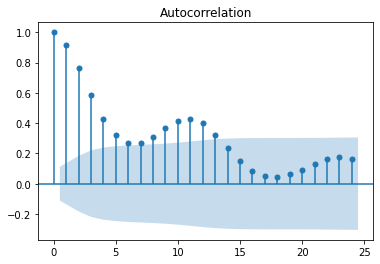

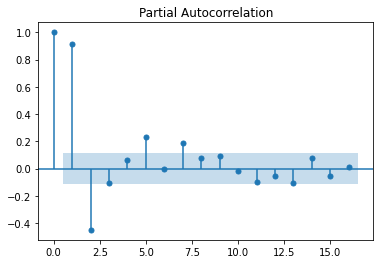

In [7]:
plot_acf(sadj_ma, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_ma, lags=16, alpha=.05, use_vlines=True)
print()

In [8]:
_, lbox_pval = acorr_ljungbox(sadj_ma, lags=12)
lbox_pval

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([5.39297667e-058, 8.28809638e-096, 7.77873612e-118, 5.12603484e-129,
       5.02218928e-135, 7.71851970e-139, 9.98782574e-143, 3.57896742e-148,
       3.00430606e-156, 4.60954016e-167, 1.19947114e-178, 1.31770509e-188])

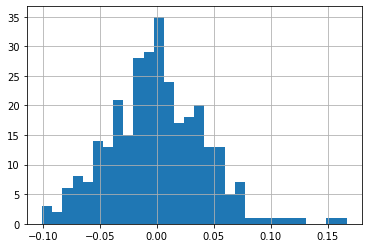

In [9]:
resid_ma = df.resid_ma.dropna().to_numpy()

plt.hist(resid_ma, bins=30)
plt.grid(True)

print()

In [10]:
qmin, qmax = np.quantile(resid_ma, q=[.03, .97])

df["outlier_ma"] = (df.consumption.values < qmin) | (df.consumption.values > qmax)

df

,date,consumption,resid_ma,sadj_ma,outlier_ma
0,1994-07-01,0.076,NaN,NaN,True
1,1994-08-01,0.097,NaN,NaN,True
2,1994-09-01,0.140,NaN,NaN,True
3,1994-10-01,0.213,NaN,NaN,True
4,1994-11-01,0.345,NaN,NaN,True
...,...,...,...,...,...
313,2020-08-01,0.005,NaN,NaN,False
314,2020-09-01,0.009,NaN,NaN,False
315,2020-10-01,0.028,NaN,NaN,False
316,2020-11-01,0.081,NaN,NaN,True


*Multiplicative Moving Average seasonal decomposition*

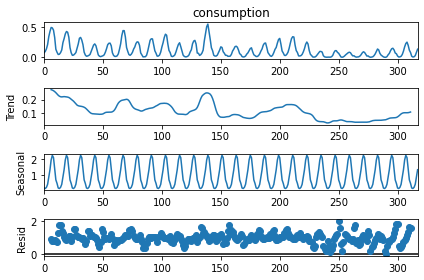

In [11]:
season_decomp_multi = seasonal_decompose(df.consumption + 1e-4, model="multiplicative", period=12)
season_decomp_multi.plot()

df["resid_ma_multi"] = season_decomp_multi.resid.to_numpy()
df["sadj_ma_multi"] = season_decomp_multi.trend.to_numpy() + season_decomp_multi.resid.to_numpy()

sadj_ma_multi = df.sadj_ma_multi.dropna().to_numpy()

In [28]:
print(adfuller(sadj_ma_multi, maxlag=12))

(-4.0567043918637555, 0.0011410291312063034, 12, 293, {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}, -51.93188452547349)


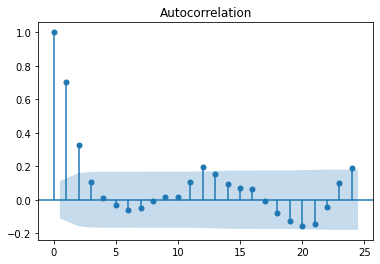

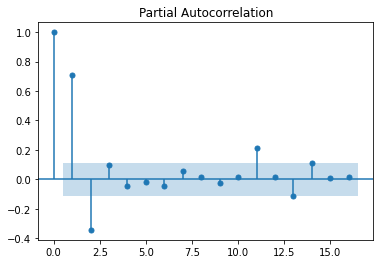

In [12]:
plot_acf(sadj_ma_multi, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_ma_multi, lags=16, alpha=.05, use_vlines=True)
print()

In [13]:
_, lbox_pval = acorr_ljungbox(sadj_ma_multi, lags=12)
lbox_pval

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([3.14034133e-35, 3.64882053e-41, 6.41234964e-41, 5.44982922e-40,
       3.43952208e-39, 1.23981376e-38, 5.10532366e-38, 2.77671505e-37,
       1.36593752e-36, 6.22257652e-36, 5.04658598e-36, 6.11589300e-38])

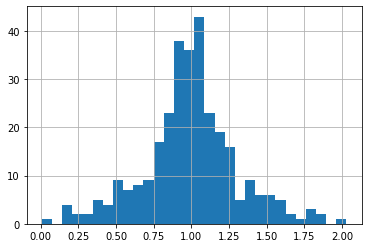

In [14]:
resid_ma_multi = df.resid_ma_multi.dropna().to_numpy()

plt.hist(resid_ma_multi, bins=30)
plt.grid(True)

print()

In [15]:
qmin, qmax = np.quantile(resid_ma_multi, q=[.03, .97])

df["outlier_ma_multi"] = (df.consumption.values < qmin) | (df.consumption.values > qmax)

df

,date,consumption,resid_ma,sadj_ma,outlier_ma,resid_ma_multi,sadj_ma_multi,outlier_ma_multi
0,1994-07-01,0.076,NaN,NaN,True,NaN,NaN,True
1,1994-08-01,0.097,NaN,NaN,True,NaN,NaN,True
2,1994-09-01,0.140,NaN,NaN,True,NaN,NaN,True
3,1994-10-01,0.213,NaN,NaN,True,NaN,NaN,True
4,1994-11-01,0.345,NaN,NaN,True,NaN,NaN,True
...,...,...,...,...,...,...,...,...
313,2020-08-01,0.005,NaN,NaN,False,NaN,NaN,True
314,2020-09-01,0.009,NaN,NaN,False,NaN,NaN,True
315,2020-10-01,0.028,NaN,NaN,False,NaN,NaN,True
316,2020-11-01,0.081,NaN,NaN,True,NaN,NaN,True


*Further analysis (maybe to be omitted)*

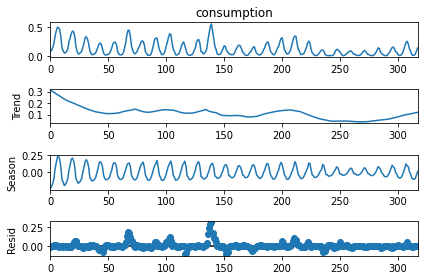

In [16]:
stl_decomp = STL(df.consumption, period=12, seasonal=7, robust=True).fit()
stl_decomp.plot()

df["resid_stl"] = stl_decomp.resid.to_numpy()

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


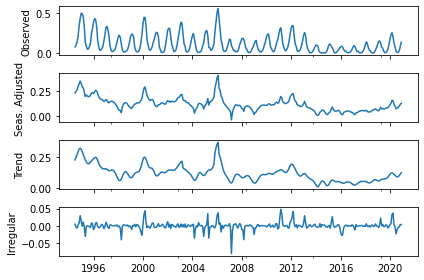

In [17]:
x13_results = x13_arima_analysis(
    pd.Series(df.consumption.values + 1e-4, index=df.date.values),
    maxorder=(2,2),
    maxdiff=(1,1),
    outlier=True,
    forecast_periods=12
)
x13_results.plot()

df["resid_x13"] = x13_results.seasadj.to_numpy()

Text(0.5, 1.0, 'Trend sezonowy dla dekompozycji X13')

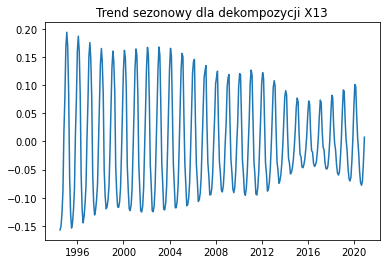

In [18]:
season_x13 = x13_results.observed - x13_results.seasadj
plt.plot(season_x13)
plt.title("Trend sezonowy dla dekompozycji X13")

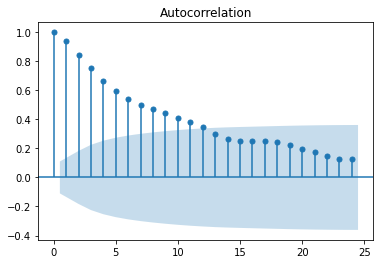

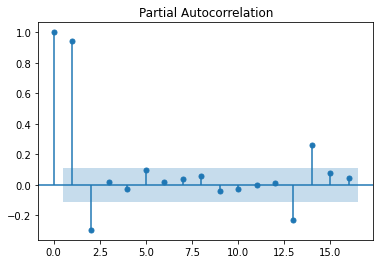

In [19]:
sadj_stl  = stl_decomp.trend.dropna().to_numpy() + stl_decomp.resid.dropna().to_numpy()
plot_acf(sadj_stl, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_stl, lags=16, alpha=.05, use_vlines=True)
print()

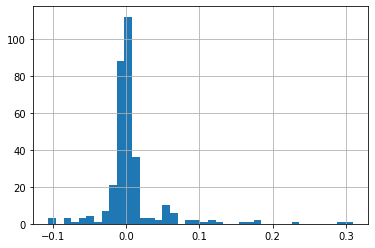

In [25]:
resid_stl = stl_decomp.resid.dropna().to_numpy()

plt.hist(resid_stl, bins=40)
plt.grid(True)

print()

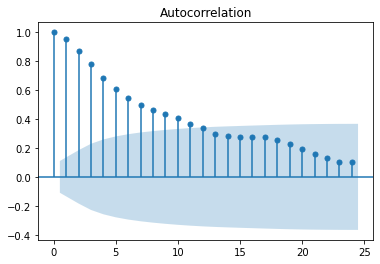

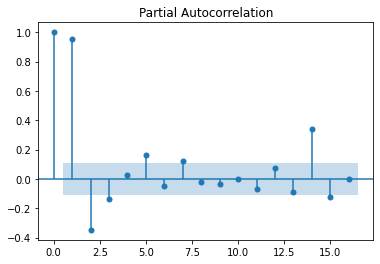

In [21]:
sadj_x13  = x13_results.seasadj.dropna().to_numpy()
plot_acf(sadj_x13, lags=24, alpha=.05, use_vlines=True)
plot_pacf(sadj_x13, lags=16, alpha=.05, use_vlines=True)
print()

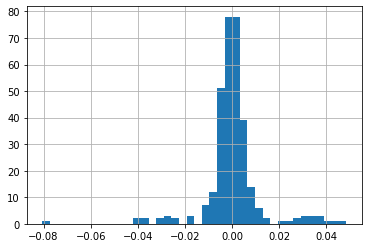

In [26]:
resid_x13 = x13_results.irregular.dropna().to_numpy()

plt.hist(resid_x13, bins=40)
plt.grid(True)

print()

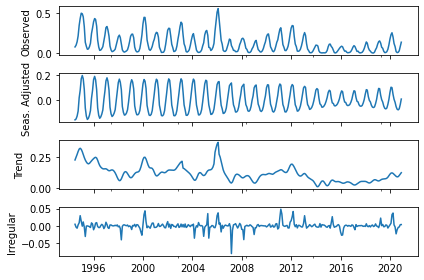

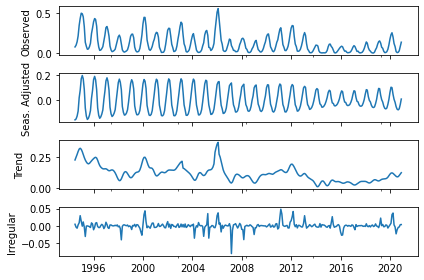

In [23]:
x13_results.seasadj = (x13_results.observed - x13_results.seasadj)
x13_results.plot()

In [24]:
# df_stat_test = pd.DataFrame(columns=["var", "test", "diff", "reg", "stat", "pval"])
# for var in ["consumption", "resid_ma", "resid_stl", "resid_x13"]:
#     for diff in [False, True]:
#         for reg in ["c", "ct"]:
#             if diff:
#                 ts = df[var].diff()
#             else:
#                 ts = df[var]
#
#             ts = ts.dropna().to_numpy()
#             n = len(df_stat_test)
#
#             stat, pval, _, _ = kpss(ts, nlags=12, regression=reg)
#             df_stat_test.loc[n] = [var, "kpss", diff, reg, stat, round(pval, 4)]
#             stat, pval, _, _, _, _ = adfuller(ts, maxlag=12, regression=reg)
#             df_stat_test.loc[n+1] = [var, "adf", diff, reg, stat, round(pval, 4)]
#
# df_stat_test = df_stat_test.sort_values(["var", "test"])
# df_stat_test